In [14]:
import torch
from matplotlib import pyplot as plt
import numpy as np

from sainomore.data import copying
from sainomore.xai import ElissabethWatcher, get_alphabet_projection

In [16]:
model_id = "l6lbw864"

In [17]:
config = {
    "n_samples": 500,
    "context_length": 100,
    "n_categories": 5,
    "to_copy": 2,

    "lr": 5e-3,
    "weight_decay": 1e-4,
    "epochs": 1001,

    "batch_size": 64,
    "val_size": 0.2,
}

In [18]:
watcher = ElissabethWatcher.load(model_id, on_cpu=True)

In [19]:
torch.random.manual_seed(62)
np.random.seed(62)
x, y = copying(
    n_samples=1,
    length=watcher.model.config("context_length"),
    n_categories=watcher.model.config("input_vocab_size"),
    to_copy=10,
)

In [20]:
print(x[0, :10], "\n", y[0, -10:], "\n", watcher.model(x).argmax(-1)[0, -10:])

tensor([2, 0, 1, 1, 3, 3, 2, 5, 1, 4]) 
 tensor([2, 0, 1, 1, 3, 3, 2, 5, 1, 4]) 
 tensor([2, 0, 1, 1, 3, 3, 2, 5, 1, 4])


In [21]:
proj = get_alphabet_projection(watcher.model)
proj[2].shape

torch.Size([10, 10, 100])

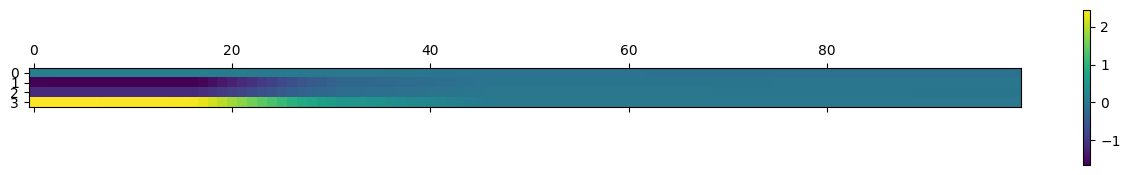

In [22]:
# torch.testing.assert_close(proj[0][0], proj[0][1])
plt.matshow(proj[0][0]-proj[0][6])
plt.colorbar()

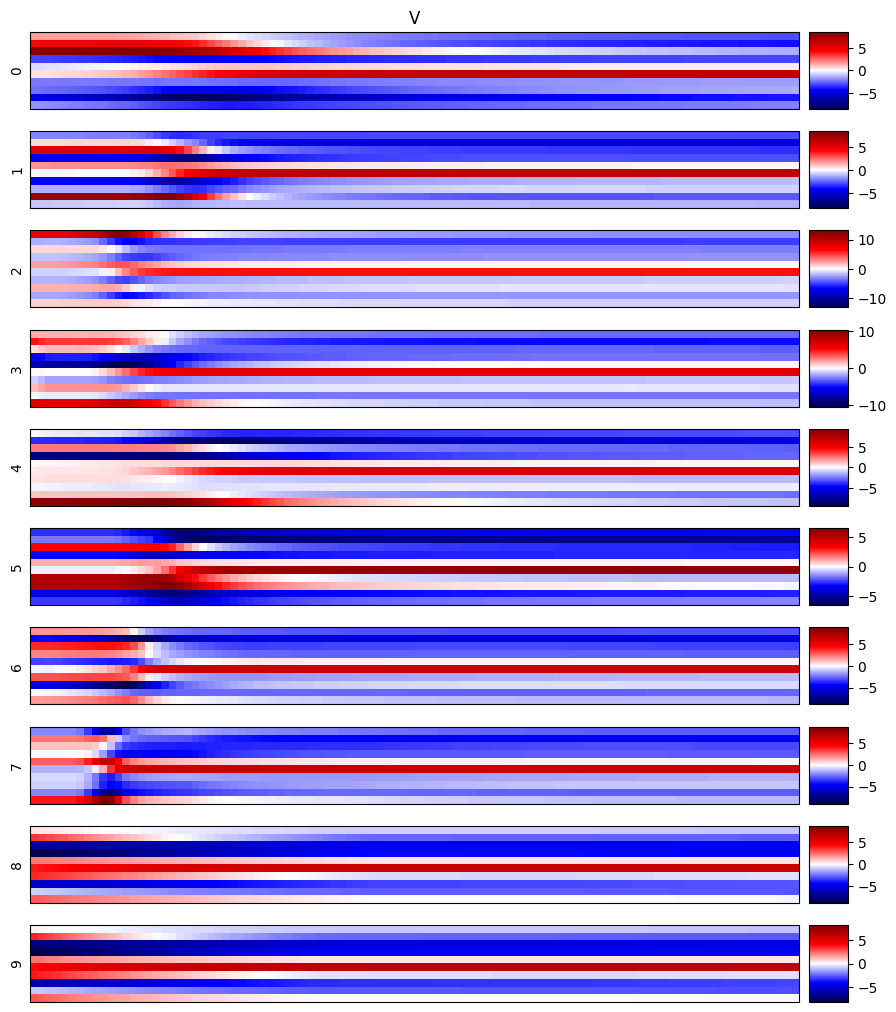

In [25]:
fig, ax = watcher.plot_alphabet_projection(
    q=False,
    k=False,
    v=True,
    n=4,
    transpose=True,
    figsize=(30, 10),
)
fig.savefig(
    f"copying_values_{model_id}.pdf",
    facecolor=(0, 0, 0, 0),
    bbox_inches="tight",
)

In [7]:
# fig, ax = watcher.plot_iss_time(
#     x[0],
#     x_axis=watcher.model(x).argmax(-1)[0, :],
#     append_dims=(1, ),
#     project_heads=True,
#     project_values=False,
#     figsize=(20, 4),
# )
# fig, ax = watcher.plot_iss(
#     x[0],
#     append_dims=(1, ),
#     project_heads=False,
#     project_values=False,
#     figsize=(10, 20),
# )

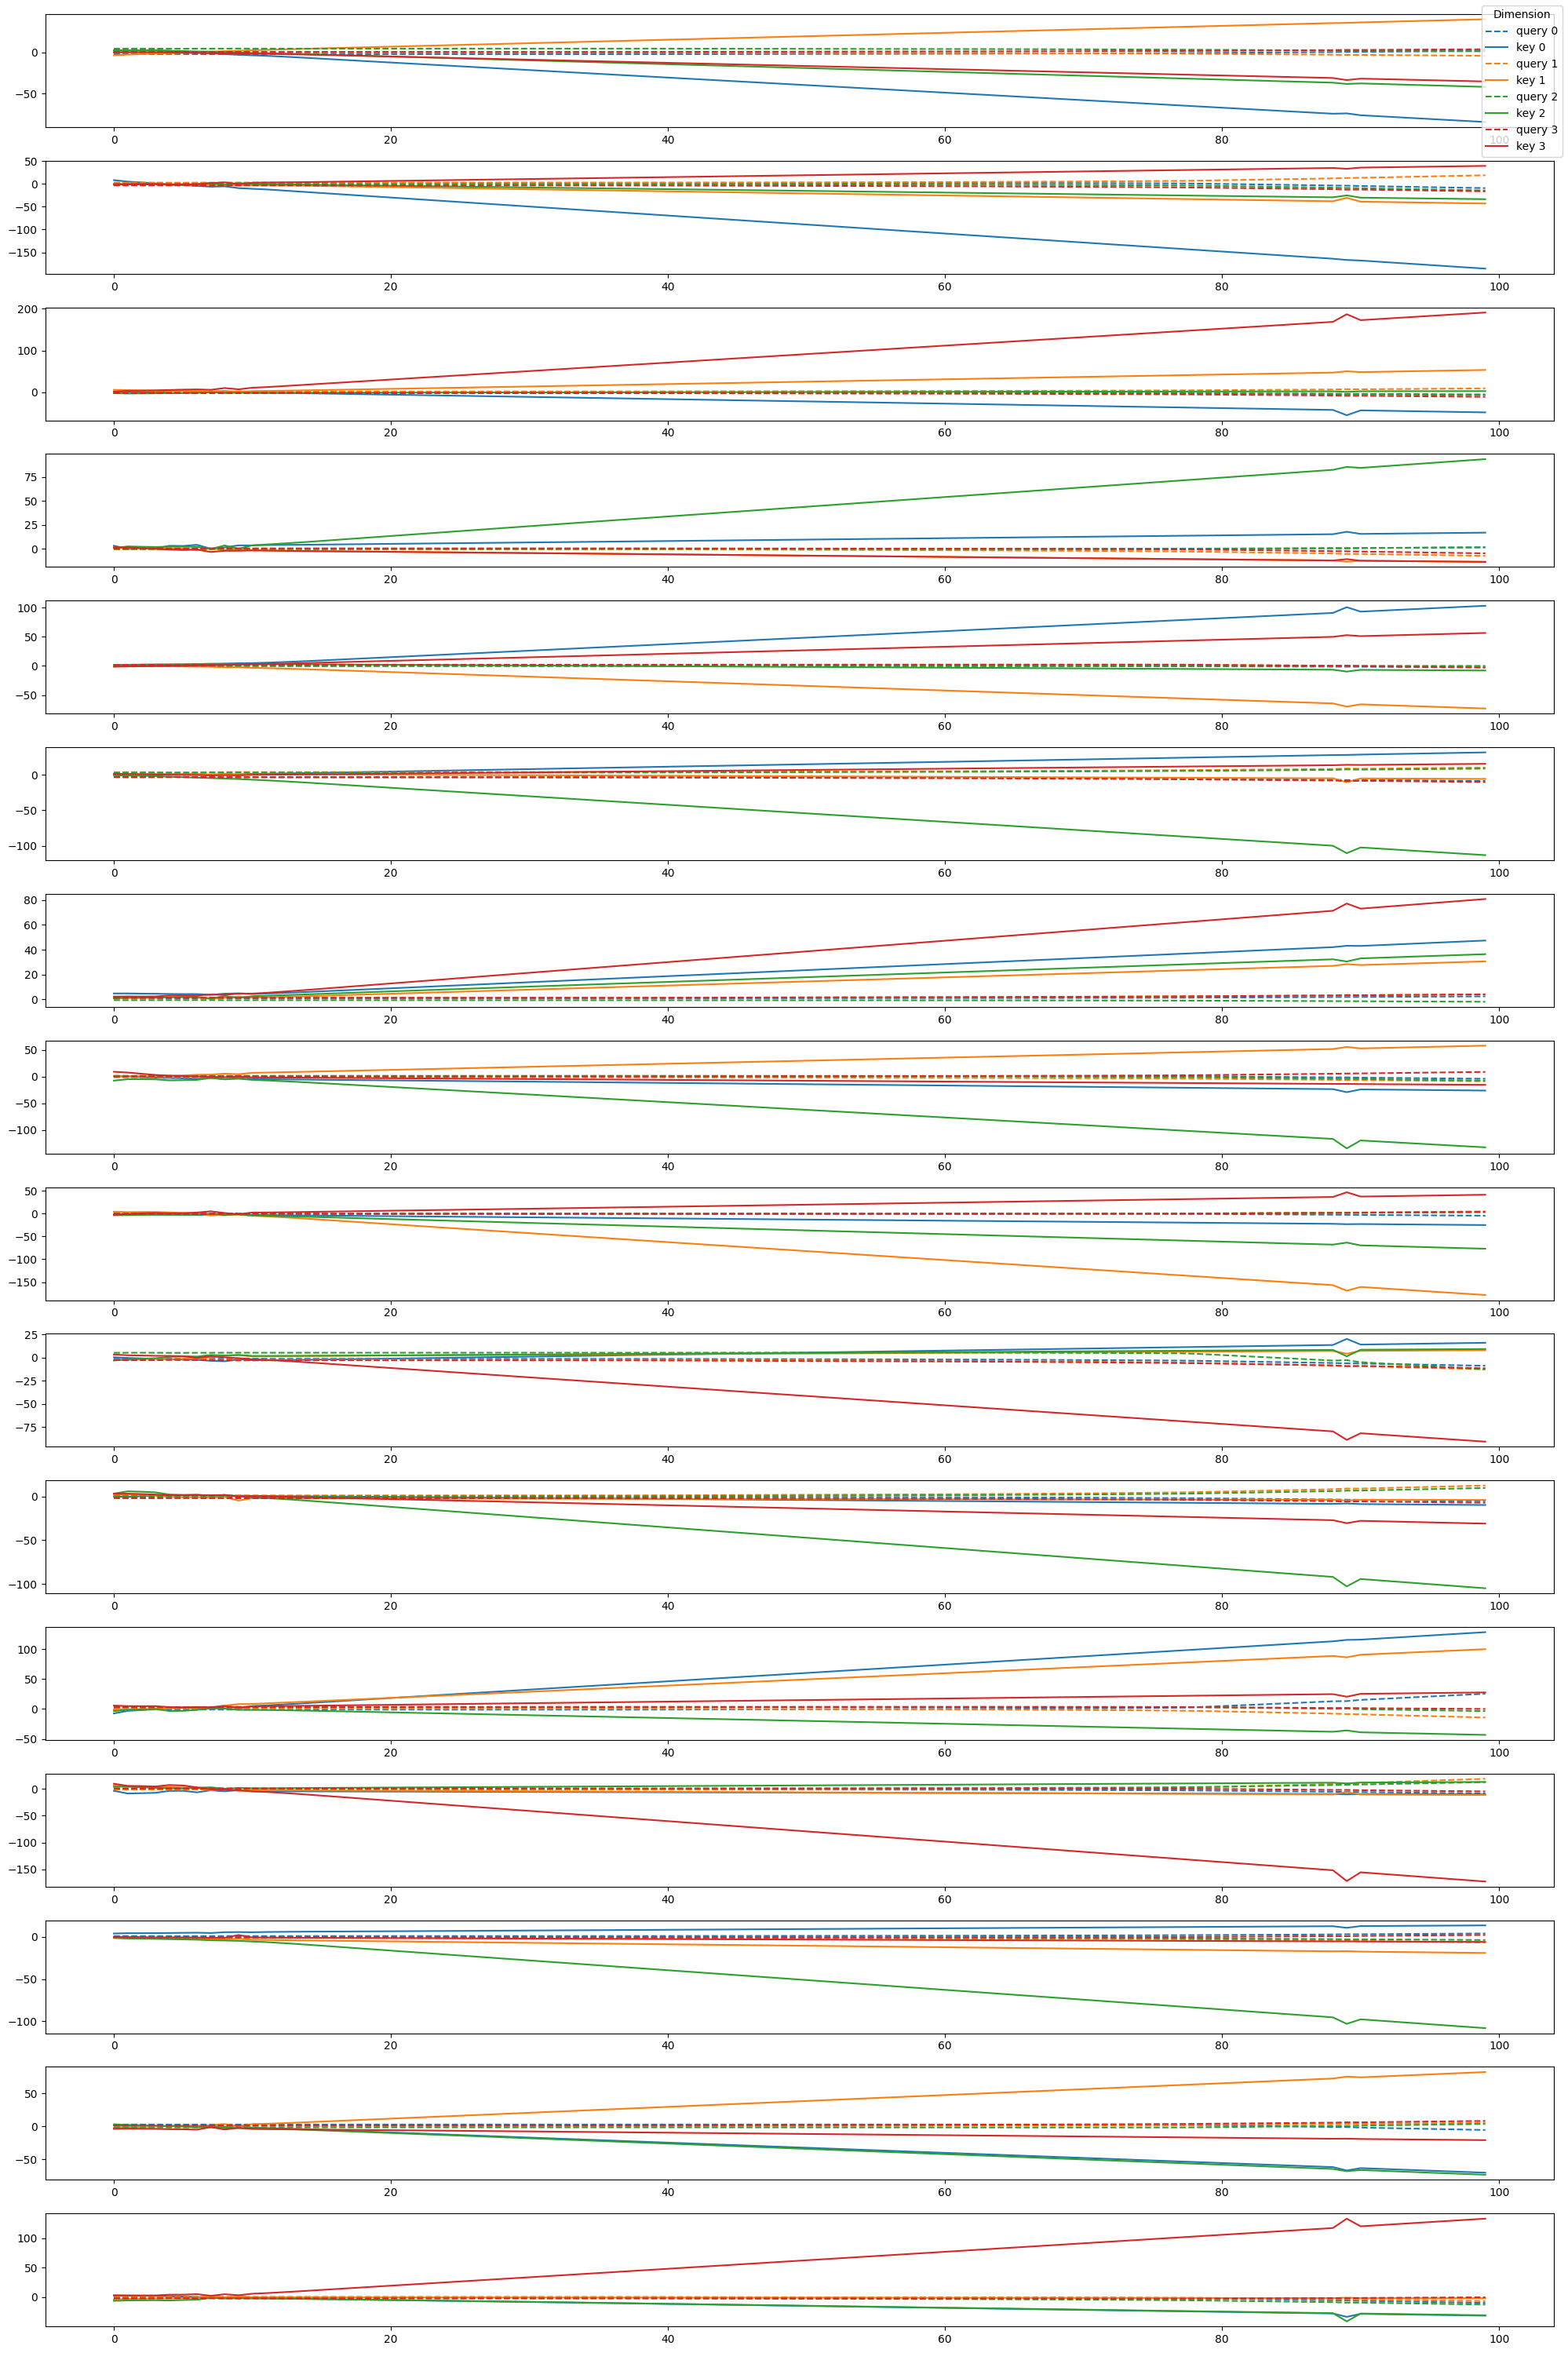

In [8]:
fig, ax = watcher.plot_query_key_time(
    x[0],
    weighting=0,
    names=("query", "key"),
    cmap="tab10",
    # x_axis=x[0],
    project_heads=False,#tuple(torch.where(W_H.abs()[0] > 5)[0].numpy()),
    # reduce_dims={0: 0},
    figsize=(20, 30),
)

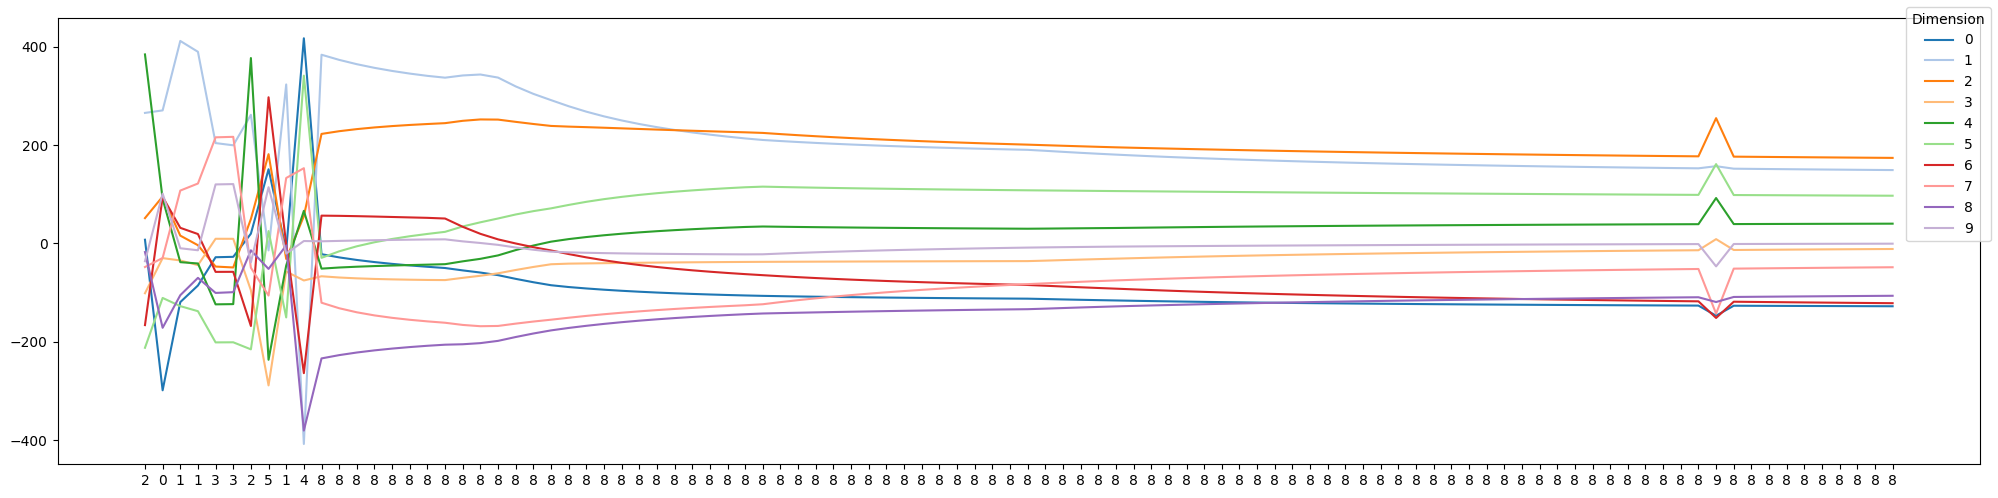

In [21]:
fig, ax = watcher.plot_values_time(
    x[0],
    x_axis=x[0],
    project_heads=True,#tuple(torch.where(W_H.abs()[0] > 5)[0].numpy()),
    # reduce_dims={0: 0},
    figsize=(20, 5),
)

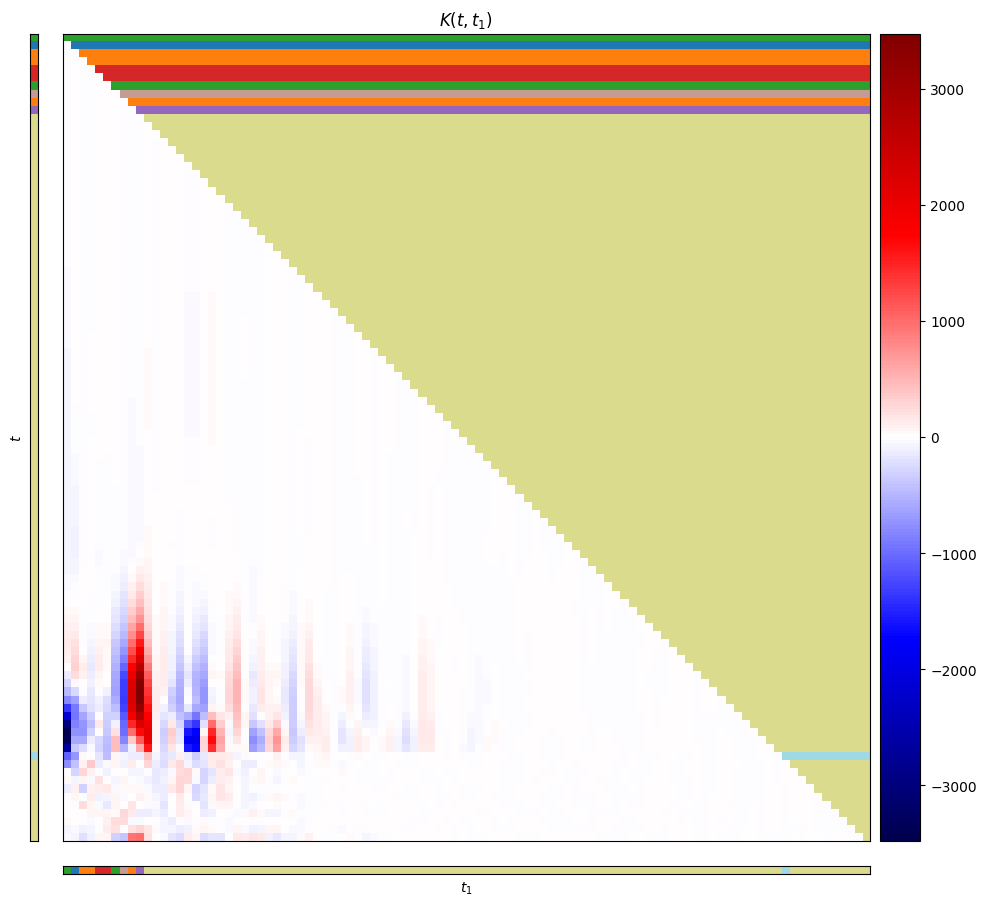

In [26]:
fig, ax = watcher.plot_attention_matrices(
    x[0],
    # total=True,
    cmap="seismic",
    share_cmap=False,
    log_cmap=False,#(10, 1),
    causal_mask=True,
    only_kernels=None,
    project_heads=True,#tuple(torch.where(W_H.abs()[0] > 5)[0].numpy()),
    center_zero=True,
    cmap_example="tab20",
    figsize=(10, 10),
)
fig.savefig(
    f"copying_attention_{model_id}.pdf",
    facecolor=(0, 0, 0, 0),
    bbox_inches="tight",
)

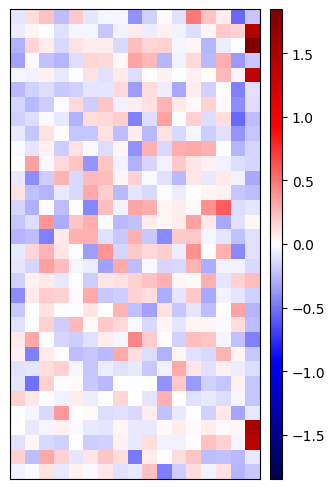

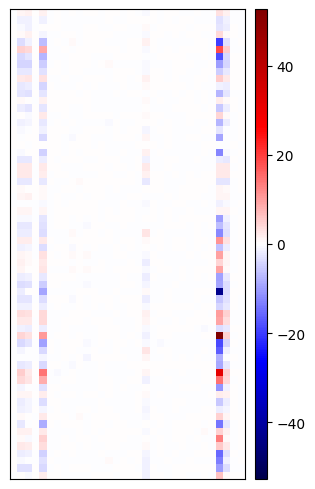

In [48]:
fig, ax = watcher.plot_parameter_matrix(
    "layers.0.levels.0.weightings.0.P_Q.transform.0.weight",
    figsize=(10, 5),
)
fig, ax = watcher.plot_parameter_matrix(
    "layers.0.levels.0.weightings.0.P_Q.transform.2.weight",
    # log_cmap=(0.1, 1.0),
    figsize=(10, 5),
)

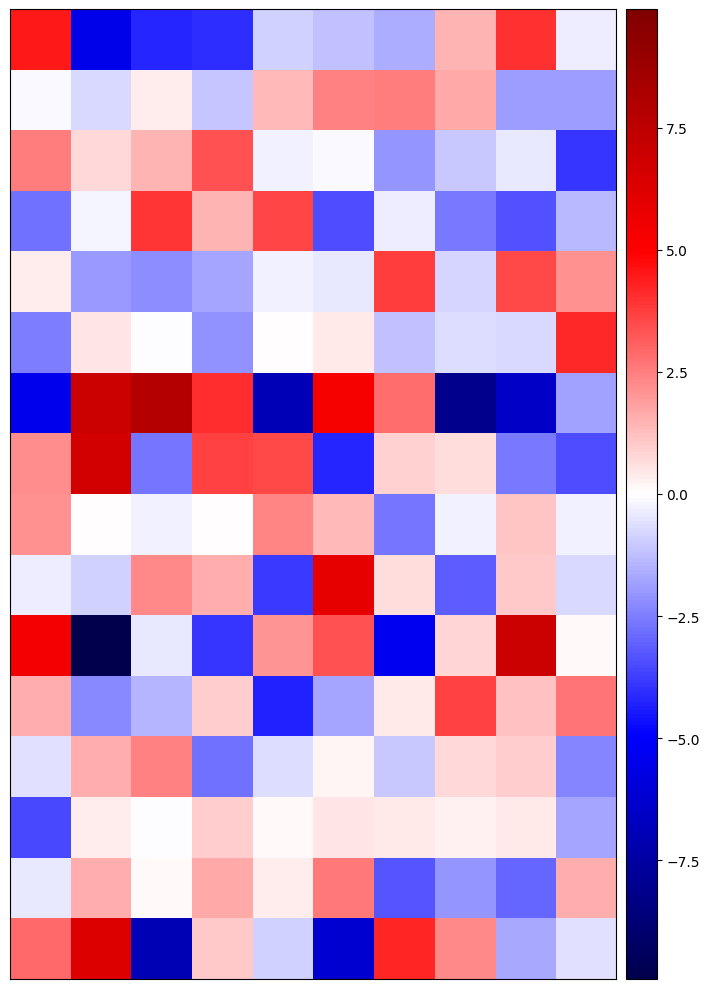

In [ ]:
fig, ax = watcher.plot_parameter_matrix(
    "layers.0.W_O",
    reduce_dims={2: 0},
    append_dims=(0,1,),
    figsize=(10, 10),
)

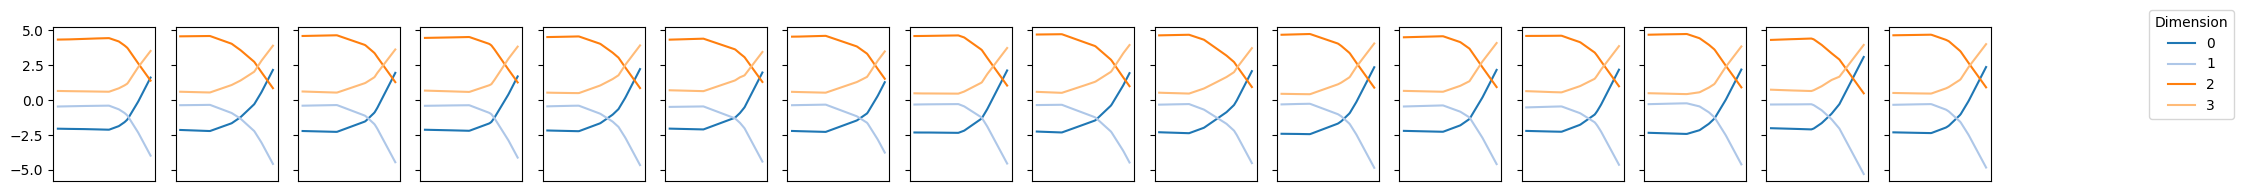

In [25]:
fig, ax = watcher.plot_qkv_probing(
    which="q",
    layer=0,
    length=0,
    weighting=0,
    reduce_dims={2: 0},
    append_dims=(2,),
    figsize=(25, 2),
)

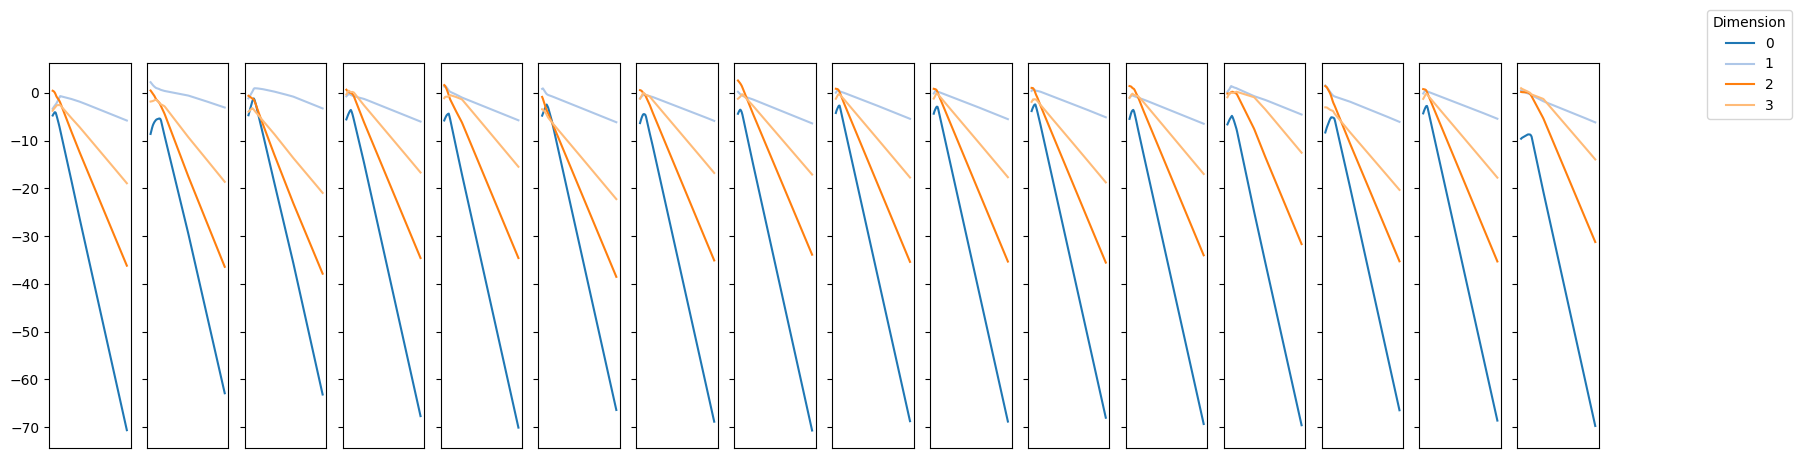

In [ ]:
fig, ax = watcher.plot_qkv_probing(
    which="k",
    layer=0,
    length=0,
    weighting=0,
    reduce_dims={2: 0},
    append_dims=(2,),
    figsize=(20, 5),
)

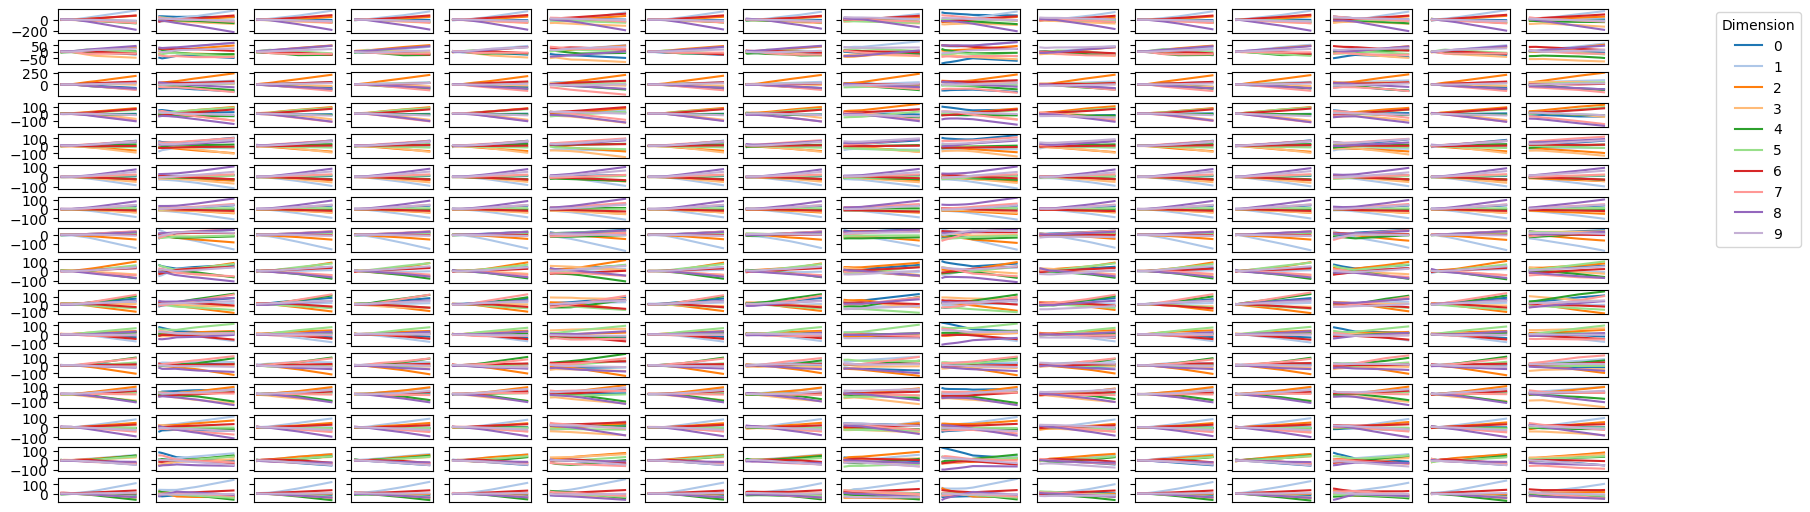

In [ ]:
fig, ax = watcher.plot_qkv_probing(
    which="v",
    layer=0,
    length=0,
    weighting=0,
    figsize=(20, 5),
)